# Training a Generative-Adversarial Network

In our previous chapters, we've focused on classification networks: taking an input and outputting a fixed label.  In this chapter, we'll examine generative networks: instead of simply classifying an image as containing a cat, these networks allow us to create new images of cats!  Cute lovers rejoice!

Most GAN research focuses on real life images from the CIFAR or ImageNet datasets.  For this section we'll pick a different type of image -- icons -- and see if we can generate realistic icons from scratch.

## Data collection

To train our GAN, we'll need a set of real icons to compare against.  Unfortunately, no such download is trivially available, so you'll have to do a little bit of manual work to acquire the data.

Start here: https://icons8.com/app/ and download the app.  Open up the resulting DMG image, right click, and select "Show Package Contents".  Now copy out the resources/icons.tar.gz file to somewhere on your file system and extract the contents.  We'll assume it's at ~/.cache/dl-cookbook/icons/.

On Linux and Windows, you can use 7z to extract the DMG contents and access icons.tar.gz


## Loading the data

Our icon data is store as a LevelDB database.  Python wrappers exist for LevelDB, making it easy to read.  Each icon record is in a custom format which we don't have a parser for.  We'll do our best to pull out the information we want: namely, the category and icon SVG itself.  Fortunately, the format appears to be consistent across the vast majority of the icons -- we ignore any icons we can't parse.

In [1]:
import os
import nb_utils
DB_LOCATION = os.path.expanduser('~/.cache/dl-cookbook/icons/')

import leveldb
ldb = leveldb.LevelDB(DB_LOCATION)

Using TensorFlow backend.


In [2]:
import itertools, io
import numpy as np
import sys
from cairosvg import svg2png
import scipy.ndimage
from PIL import Image

noise_size = 100
img_width = 32
img_height = 32

l_iter = ldb.RangeIter(None, None)


def load_image(v):
    try:
        cat = v.replace(b'\x00', b'').split(b'\x08')[2].decode('utf8')
        
        start_idx = v.find(b'<?xml')
        end_idx = v.find(b'</svg>')
        v = v[start_idx:end_idx+6]    
        png = svg2png(bytestring=bytes(v))        
        
        with io.BytesIO(png) as f:
            img = Image.open(f)
            img.load()
            img = img.resize((img_width, img_height))
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3]) # 3 is the alpha channel
            img = background.convert('L')
            return np.asarray(img), cat
    except:
        print(sys.exc_info())
        return None

import multiprocessing
with multiprocessing.Pool() as pool:
    handles = []
    for k,v in l_iter:
        handles.append(pool.apply_async(load_image, (v,)))
    
    results = [h.get() for h in handles]
    results = [r for r in results if r is not None]
    images = [r[0] for r in results]
    categories = [r[1] for r in results]

(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2e10a08>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2dba848>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2dcc488>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2dcfec8>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9d743c5a08>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2d1b088>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2d5fe88>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2e0e8c8>)
(<class 

(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9d743856c8>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9d743ce0c8>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9d743e0908>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2d4fd48>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9d743be448>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2d64848>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9d743b14c8>)
(<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x7f9cd2d50ac8>)
(<class 

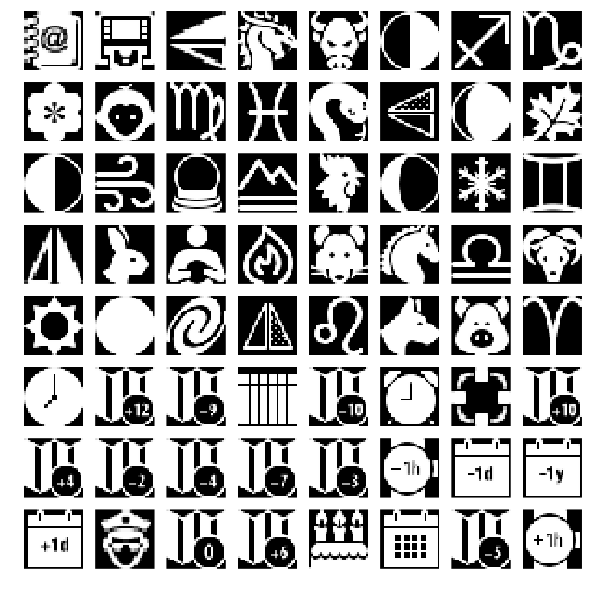

In [3]:
%matplotlib inline
nb_utils.plot_images(images[:64])

## Prepping our data

Before training our network, we want to normalize our data to make the models work a little easier: we'll normalize all of our images to have values between -1 and 1.  We'll also transform our categories we collected up above into labels from [0, num_labels].  We will use these labels to pre-train our discriminator network.

In [4]:
img_array = np.asarray(
    [2 * (img / (1e-9 + img.max()) - 0.5) for img in images]
)

# add a single dimension for our grayscale value, for compatibility with our models.
img_array = img_array[:,:,:,np.newaxis]

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(categories)

# Shuffle our data before processing it further.
shuffle_idx = np.arange(img_array.shape[0])
np.random.shuffle(shuffle_idx)
img_array = img_array[shuffle_idx]
category_labels = category_labels[shuffle_idx]

In [5]:
category_labels.shape, img_array.shape

((43800,), (43800, 32, 32, 1))

In [6]:
## Let's take a quick look at what our categories are like.

import collections
collections.Counter(categories)

Counter({'': 1,
         'Alphabet': 561,
         'Animals': 744,
         'Arrows': 940,
         'Astrology': 384,
         'Baby': 402,
         'Beauty': 569,
         'Business': 1774,
         'Cinema': 1271,
         'City': 1080,
         'Clothing': 755,
         'Computer Hardware': 641,
         'Crime': 120,
         'Culture': 537,
         'DIY': 357,
         'Data': 978,
         'Drinks': 241,
         'Ecommerce': 1155,
         'Editing': 1437,
         'File Types': 2,
         'Files': 956,
         'Finance': 812,
         'Flags': 274,
         'Folders': 194,
         'Food': 1006,
         'Free Popular': 587,
         'Gaming': 843,
         'Hands': 241,
         'Healthcare': 936,
         'Holidays': 475,
         'Household': 1971,
         'Industry': 1087,
         'Logos': 2223,
         'Maps': 660,
         'Media Controls': 315,
         'Messaging': 1267,
         'Military': 509,
         'Mobile': 766,
         'Music': 523,
         'Nature': 15

# Trying CIFAR instead...

In [7]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train -= 0.5
x_test -= 0.5

## Building our network

Now that we have our icons, let's build our GAN network.  The basic idea with a GAN network is to construct 2 sub-networks that we will have "fight" against each other.

* Generator: this network starts with a random data seed, and it's goal is to generate an image that fools the discriminator
* Discriminator: this network is presented an image, and must decide whether it is a real image, or a fake generated by the generator network

By playing these networks against each other, we can cause the generator network to produce more and more convincing "fakes".

### Generator Network

Our generator network is effectively an upside down convolutional network.  Normal CNNs start with an image and producing a small dimensional label.  A generative network starts with a small random seed ("label"), and runs inverted CNN to produce successively larger images.

In [8]:
import keras
from keras.models import Model
import keras.layers as L
import keras.backend as K


# Using https://github.com/ctmakro/hellotensor/blob/master/lets_gan_clean.py
# as a basis

def adam():
    return keras.optimizers.Adam(lr=0.00005, beta_1=0.5)

def build_gen_network(seed_shape):
    input = L.Input(shape=(seed_shape,))
    transformed = L.Dense(4*4*256)(input)
    reshaped = L.Reshape((4,4,256))(transformed)
    reshaped = L.Activation('relu')(reshaped)    
    
    def deconv(layer, num_filters, kernel_size, strides, normalize=True, padding='same'):
        layer = L.Conv2DTranspose(
            num_filters, (kernel_size, kernel_size), 
            padding=padding,
            strides=strides)(layer)
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.Activation('relu')(layer)
        return layer

    reshaped = deconv(reshaped, 256, 5, padding='same', strides=2)
    reshaped = deconv(reshaped, 128, 5, padding='same', strides=2)
    reshaped = deconv(reshaped, 3, 5, normalize=False, strides=2)    
    reshaped = L.Activation(activation='tanh')(reshaped)
    
    return Model(inputs=[input], outputs=[reshaped])

gen_network = build_gen_network(noise_size)
gen_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         1638656   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)         0         
__________

### Discriminator Network

Our discriminator network is just a standard CNN, and looks like the inverse of our generator.  We stack a number of CNN layers, terminating in dense layer with a single output to decide if we are looking at a real or fake image.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        2432      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

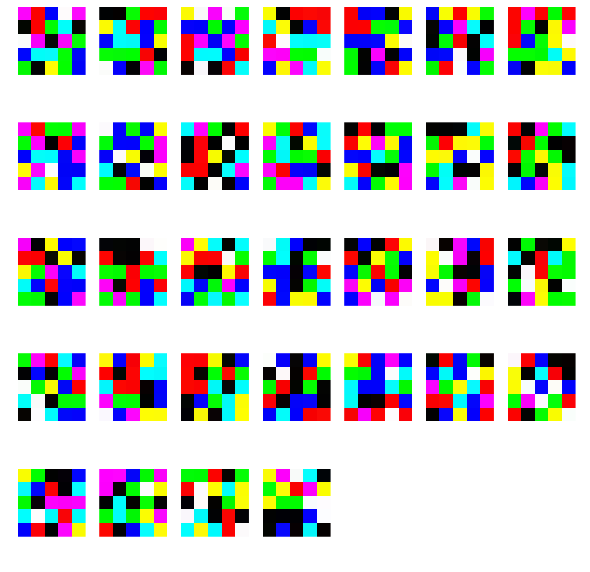

In [9]:
def build_discriminator_network():
    input = L.Input(shape=(img_width, img_height, 3))
    def conv(layer, num_filters, kernel_size, strides, normalize=True, padding='same'):
        layer = L.Conv2D(
            num_filters, kernel_size, 
            padding=padding,
            kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            strides=strides)(layer)
        
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.LeakyReLU(0.2)(layer)
        
        return layer
    
    l = conv(input, 32, kernel_size=5, strides=2)
    l = conv(l, 64, kernel_size=5, strides=2)
    l = conv(l, 128, kernel_size=5, strides=2)
    l = L.Flatten()(l)
    
    discriminator = L.Dense(units=1, 
                            kernel_initializer=keras.initializers.RandomNormal(stddev=0.02),
                            activation='sigmoid')(l)
    label = L.Dense(units=len(label_encoder.classes_), activation='softmax')(l)
    
    return (
        Model(inputs=[input], outputs=[discriminator]),
        Model(inputs=[input], outputs=[label]),
    )

dis_net, label_net = build_discriminator_network()

label_net.compile(loss='sparse_categorical_crossentropy', optimizer=adam(),metrics=['accuracy'])
dis_net.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])

dis_net.summary()


conv_0_original = label_net.get_weights()[0]
nb_utils.plot_images(conv_0_original.transpose((3, 0, 1, 2)))

## Pretraining our discriminator network

To help our real training converge faster, we pre-train our discriminator network to determine which category an icon comes from.  Because the label network shares most of it's layers with the discriminator network, this ensures the early layers of our discriminator network will have useful values.

In [10]:
label_net.fit(
    x_train, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.05,
)

Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 6s - loss: 2.0108 - acc: 0.3473 - val_loss: 2.9056 - val_acc: 0.1056
Epoch 2/5
47500/47500 [==============================] - 5s - loss: 1.4847 - acc: 0.4766 - val_loss: 2.5104 - val_acc: 0.1800
Epoch 3/5
47500/47500 [==============================] - 5s - loss: 1.3430 - acc: 0.5272 - val_loss: 1.6982 - val_acc: 0.3960
Epoch 4/5
47500/47500 [==============================] - 5s - loss: 1.2581 - acc: 0.5610 - val_loss: 1.3259 - val_acc: 0.5288
Epoch 5/5
47500/47500 [==============================] - 5s - loss: 1.1914 - acc: 0.5848 - val_loss: 1.2603 - val_acc: 0.5604


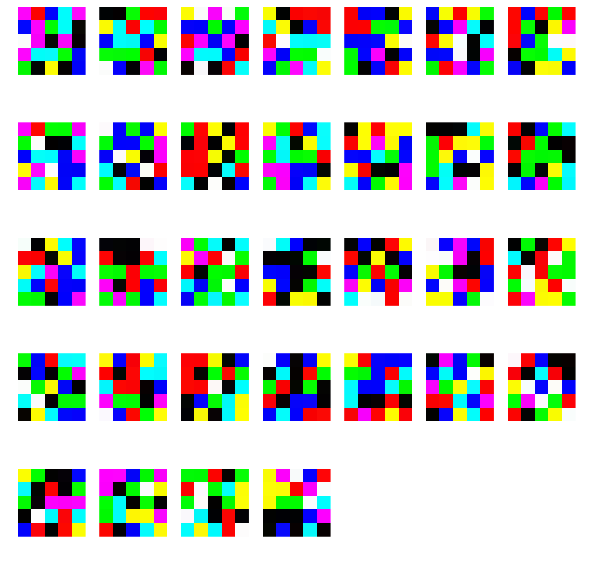

In [11]:
conv_0 = label_net.get_weights()[0] + label_net.get_weights()[1]
nb_utils.plot_images(conv_0.transpose((3, 0, 1, 2)))

## Combined Model

Now let's build the combined model which runs both our generator and discrimnator: this will be used for training.

In [12]:
gan_input = L.Input(gen_network.input_shape[1:])
GAN = Model(gan_input, 
            dis_net(gen_network(gan_input)))
GAN.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         2882819   
_________________________________________________________________
model_2 (Model)              (None, 1)                 261569    
Total params: 3,144,388
Trainable params: 3,143,172
Non-trainable params: 1,216
_________________________________________________________________


## Training the GAN

Now we're finally ready to train the generator network.  We do this by alternating the following:

* Generate a batch of images G
* Train the discriminator to distinguish true images from G
* Generate a new batch G'
* Train the generator based on how well G' fooled the discriminator

In [13]:
batch_size = 64
total_examples = 250 * 1000

class Stat(object):
    def __init__(self, name):
        self._v = []
        self.name = name
        
    def __repr__(self):
        return '%s(%0.6f, %0.6f)' % (self.name, self.loss(), self.accuracy())
    
    def record(self, v):
        self._v.append(v)
        
    def loss(self, last=50):
        return np.mean(self._v[-last:], axis=0)[0]
    
    def accuracy(self, last=50):
        return np.mean(self._v[-last:], axis=0)[1]
    
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

d_loss_true = Stat('DTrue')
d_loss_fake = Stat('DFake')
g_loss = Stat('Gen')
samples = []
import time

start = time.time()

for i in range(total_examples // batch_size):
    # Train the discriminator network
    # Use separate batches for true and fake images
    
    # Add label noise to make the discriminator networks job harder
    image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
    d_loss_true.record(dis_net.train_on_batch(image_batch, np.ones(batch_size)))
    
    for j in range(2):
        generated = gen_network.predict(np.random.normal(size=(batch_size, noise_size)))
        d_loss_fake.record(dis_net.train_on_batch(generated, np.zeros(batch_size)))
    
    # Now train the generator network -- it should generate inputs which
    # "fool" the discriminator and cause it to produce 1s.
    # 
    # We disable updating the discriminator layers for this step: we 
    # don't want them to be penalized for (correctly) marking the fake image as fake.
    make_trainable(dis_net, False)
    g_loss.record(
        GAN.train_on_batch(np.random.normal(size=(batch_size, noise_size)), 
                           np.zeros(batch_size)))
    make_trainable(dis_net, True)
    
    if i % 100 == 0:
        gen_img = gen_network.predict(np.random.normal(size=(1, noise_size)))
        samples.append(gen_img[0])
    
    print('\r', '%5d/%5d %4.2f %s %s %s' % (
        i, total_examples/batch_size, time.time() - start, d_loss_true, d_loss_fake, g_loss),
          flush=True, end='')

  3905/ 3906 438.64 DTrue(0.000001, 1.000000) DFake(0.000000, 1.000000) Gen(0.000000, 1.000000)

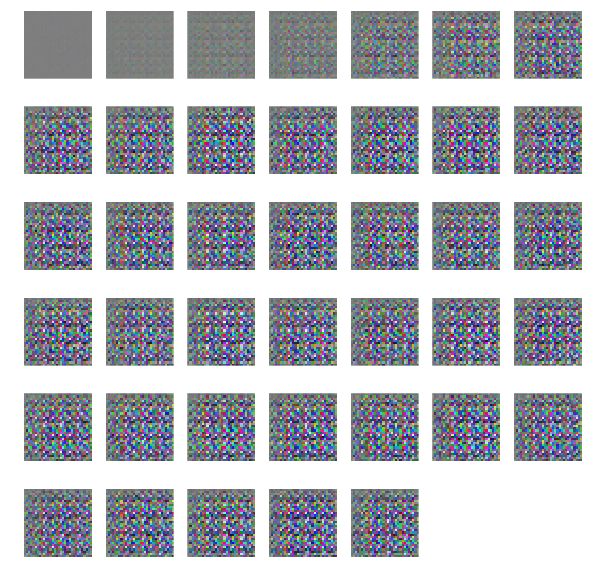

In [14]:
samples = np.asarray(samples)
n = (samples - samples.min()) / (samples.max() - samples.min())
nb_utils.plot_images(n)

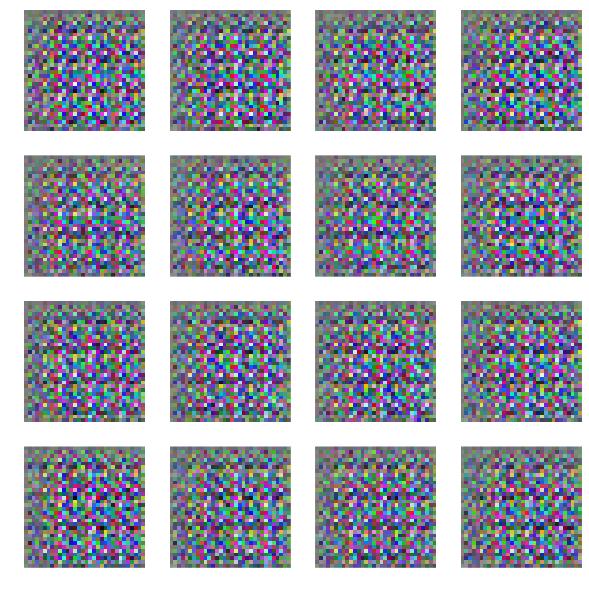

In [15]:
noise_gen = np.random.normal(0, 1, size=(16, noise_size))
generated = gen_network.predict(noise_gen)
n = (generated - generated.min()) / (generated.max() - generated.min())
nb_utils.plot_images(n)